In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class Encoder(nn.Module):
    """The encoder for VAE"""
    
    def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
        super().__init__()
        
        convs = []
        prev_dim = input_dim
        for conv_dim in conv_dims:
            convs.append(nn.Sequential(
                nn.Conv2d(prev_dim, conv_dim, kernel_size=3, stride=2, padding=1),
                nn.ReLU()
            ))
            prev_dim = conv_dim
        self.convs = nn.Sequential(*convs)
        
        prev_dim = (image_size // (2 ** len(conv_dims))) ** 2 * conv_dims[-1]
        self.fc = nn.Sequential(
            nn.Linear(prev_dim, fc_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(fc_dim, latent_dim)
        self.fc_log_var = nn.Linear(fc_dim, latent_dim)
                    
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var
    
class Decoder(nn.Module):
    """The decoder for VAE"""
    
    def __init__(self, latent_dim, image_size, conv_dims, output_dim):
        super().__init__()
        
        fc_dim = (image_size // (2 ** len(conv_dims))) ** 2 * conv_dims[-1]
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, fc_dim),
            nn.ReLU()
        )
        self.conv_size = image_size // (2 ** len(conv_dims))
        
        de_convs = []
        prev_dim = conv_dims[-1]
        for conv_dim in conv_dims[::-1]:
            de_convs.append(nn.Sequential(
                nn.ConvTranspose2d(prev_dim, conv_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU()
            ))
            prev_dim = conv_dim
        self.de_convs = nn.Sequential(*de_convs)
        self.pred_layer = nn.Sequential(
            nn.Conv2d(prev_dim, output_dim, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(x.size(0), -1, self.conv_size, self.conv_size)
        x = self.de_convs(x)
        x = self.pred_layer(x)
        return x
        

In [3]:
class VAE(nn.Module):
    """VAE"""
    
    def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
        super().__init__()
        
        self.encoder = Encoder(image_size, input_dim, conv_dims, fc_dim, latent_dim)
        self.decoder = Decoder(latent_dim, image_size, conv_dims, input_dim)
        
    def sample_z(self, mu, log_var):
        """sample z by reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sample_z(mu, log_var)
        recon = self.decoder(z)
        return recon, mu, log_var
    
    def compute_loss(self, x, recon, mu, log_var):
        """compute loss of VAE"""
        
        # KL loss
        kl_loss = (0.5*(log_var.exp() + mu ** 2 - 1 - log_var)).sum(1).mean()
        
        # recon loss
        recon_loss = F.binary_cross_entropy(recon, x, reduction="none").sum([1, 2, 3]).mean()
        
        return kl_loss + recon_loss
            

In [4]:
x = torch.rand(1, 1, 28, 28)

image_size = 28
conv_dims = [32, 64]
fc_dim = 128
latent_dim = 64

batch_size = 128
epochs = 30

transform=transforms.Compose([
    transforms.ToTensor()
])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
print_freq = 200
for epoch in range(epochs):
    print("Start training epoch {}".format(epoch,))
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        recon, mu, log_var = model(images)
        loss = model.compute_loss(images, recon, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
            print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item()))

Start training epoch 0
	 [199/469]: loss 187.67857360839844
	 [399/469]: loss 148.39346313476562
	 [468/469]: loss 150.820068359375
Start training epoch 1
	 [199/469]: loss 136.36627197265625
	 [399/469]: loss 126.92573547363281
	 [468/469]: loss 116.98076629638672
Start training epoch 2
	 [199/469]: loss 115.5693359375
	 [399/469]: loss 111.59933471679688
	 [468/469]: loss 110.3120346069336
Start training epoch 3
	 [199/469]: loss 113.01451110839844
	 [399/469]: loss 110.99957275390625
	 [468/469]: loss 107.50617218017578
Start training epoch 4
	 [199/469]: loss 108.46925354003906
	 [399/469]: loss 107.11563110351562
	 [468/469]: loss 106.11482238769531
Start training epoch 5
	 [199/469]: loss 102.81958770751953
	 [399/469]: loss 104.22434997558594
	 [468/469]: loss 106.00135040283203
Start training epoch 6
	 [199/469]: loss 103.6996841430664
	 [399/469]: loss 99.68712615966797
	 [468/469]: loss 97.84563446044922
Start training epoch 7
	 [199/469]: loss 99.5423583984375
	 [399/469]: l

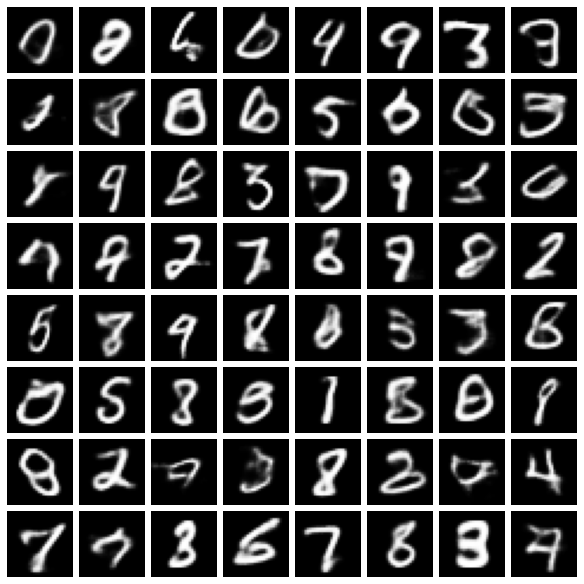

In [6]:
## generate new images by VAE

n_cols, n_rows = 8, 8

sample_zs = torch.randn(n_cols * n_rows, latent_dim)
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
    
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")


<AxesSubplot:xlabel='x1', ylabel='x2'>

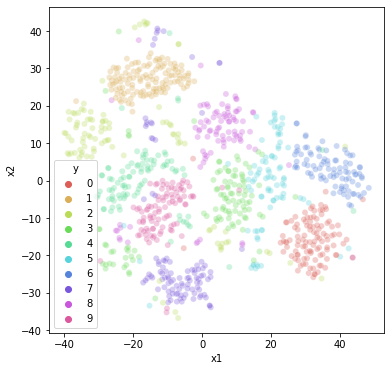

In [7]:
## visualize latent features

latent_zs = []
targets = []
for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        with torch.no_grad():
            mu, log_var = model.encoder(images)
        latent_zs.append(mu.cpu().numpy())
        targets.append(labels.numpy())
latent_zs = np.concatenate(latent_zs, 0)
targets = np.concatenate(targets, 0)

n_samples = 1000
sample_idxs = np.random.permutation(len(targets))[:n_samples]

latent_zs = latent_zs[sample_idxs]
targets = targets[sample_idxs]
zs_reduced = TSNE(n_components=2, random_state=2022).fit_transform(latent_zs)

tsne_data = pd.DataFrame({
    "x1": zs_reduced[:,0],
    "x2": zs_reduced[:,1],
    "y": targets})

plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="x1", y="x2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=tsne_data,
    legend="full",
    alpha=0.3
)   
